# PyTorch Workflow

Let's explore an example PyTorch end-to-end worflow.

In [1]:
what_were_covering = {
    1: "data {prepare and load}",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions",
    5: "saving and loading the model",
    6: "putting it all together"
}

what_were_covering

{1: 'data {prepare and load}',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions',
 5: 'saving and loading the model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural netowrks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# check PyTorch version
torch.__version__

'1.13.1'

## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

* Excel spreadsheet
* Images of nay kind
* Videos (YouTube has lots of data...)
* Audio like songs or podcasts
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical presentation.

To showcase this, let's create some *known* data using the linear regression formula (`y = mx + c -> where m is the slope and c is the y intercept`).

We'll use a linear regression formula to make s straight line with *known* **parameters**.

In [3]:
# create *known* parameters
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [5]:
# create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"`Visualize, visualize visualize!`"

In [6]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=[]):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

    # Are there predictions?
    colors = ["red", "pink", "orange", "black"]
    for i in range(len(predictions)):
        # Plot the predictions if they exist in red
        plt.scatter(test_data, predictions[i], c=colors[i % len(colors)], s=8, marker=",", label=f"Predictions={i+1}")

    # Show the legend
    plt.legend(prop={"size": 14})

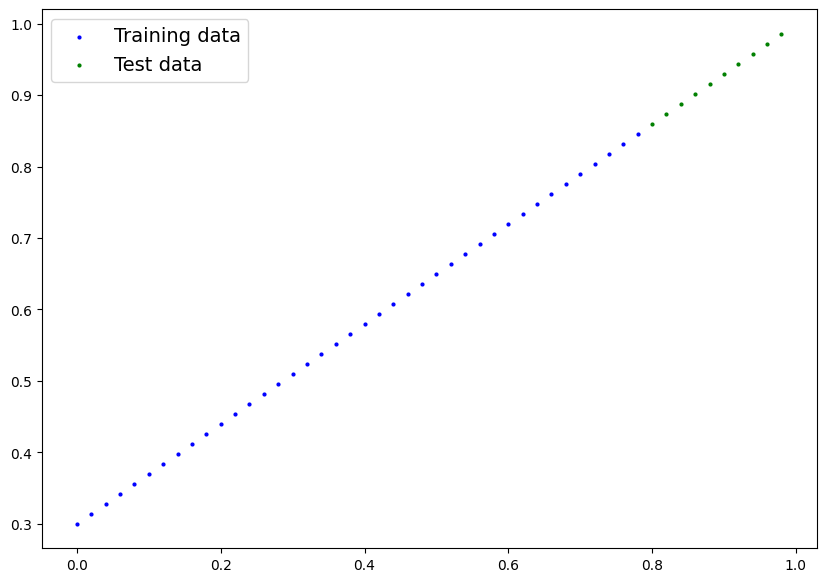

In [7]:
plot_predictions()

## 2. Build Model

Our first PyTorch model!

This is very exciting... let's do it!

What our model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represebt (or get closer to) the ideal values (the weight and bias values we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [8]:
# create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    def __init__(self) -> None:
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                               requires_grad=True, # <- can this parameter be updated via gradient descent?
                                               dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
        
        self.bias = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                             requires_grad=True, # <- can this parameter be updated via gradient descent?
                                             dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
        
    # forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weights * x + self.bias # this is the linear regression formula

### PyTorch model building essentials

* `torch.nn` - contains all of the building blocks for computational graphs (a neural network can be consider a computaional graph)
* `torch.nn.Parameter` - what parameters should out model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - the base class for all neural network modules, if you subclass it, you should overwrite forward
* `torch.optim` - this is where the optimizers in PyTroch live, they will help with gradient descent
* `def forward()` - all nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

More of these essential modules via the PyTorch cheatsheet - https://pytorch.org/tutorials/beginner/ptcheat.html

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside...

So we can check our model parameters or what's inside our model using `.parameters()`

In [9]:
# create a random seed
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference.mode()`

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass data throught our model, it's going to run it throught the `forward()` method

In [11]:
# make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# you can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred
# with torch.no_grad():
#     y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

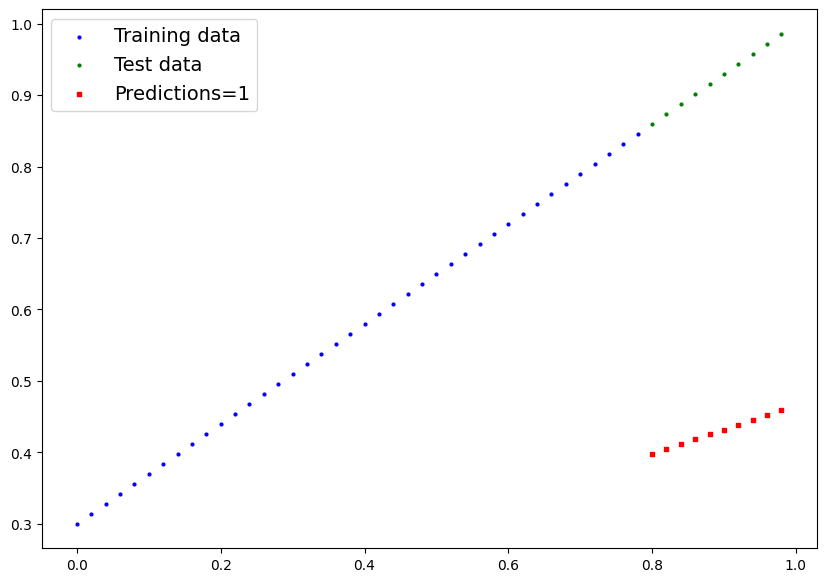

In [12]:
plot_predictions(predictions=[y_preds])

### 3. Train model

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters.

Or in other words from a poor representation of the data tot a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in different areas.

Things we need to train:

* **Loss functions:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the models's parameters (e.b. weights & bias) to improve the loss function.
    * Inside the optimizer you'll often have to set two parameters:
        * `params` - the model parametrs you'd like to optmizer, for example `params=model_0.parameters()`
        * `lr (learning rate)` - the learning rate is a hyperparamete that defines how big/small the optmizer changes the parameters with each step (a small `lr` results in small changes, a large `lr` results in large changes)

And specifically for PyTorch, we need:
1. A training loop
2. A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [14]:
# checkout our model's parameters (a parameter is a value that the model sets itself)
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.005) # lr = lerning rate = possibly the most important hyperparameter you can set

**Q:** Which loss function and optmizer should we use?

**A:** This will be problem specific. But with experience, you'll get an idea of what works and what doesn't with your particular problem set.

For example, for a regression problem (like this one), a loss function of `nn.L1Loss()` and the optmizer like `torch.optim.SGD()` will suffice.

But for a classification problem like classifying whether a photo is of a dog or a cat, you'll likely waht to use a loss function of `nn.BCELoss()` (binary cross entripy loss)

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop throught the data
1. Forward pass (this involves data moving throught our model's `forward()` functions) to make predictions on data - also called **forward propagation**
2. Calculate the loss (compare forward pass predictions to groud truth labels)
3. Optmizer zero grad
4. Loss backward - move backwards thought network to calculate the gradient of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optmizer step - use the optimizer to adjust our model's paramaters to try and improve the loss (**gradient descent**)

In [16]:
list(model_0.eval().parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
list((model_0.parameters()))

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [19]:
torch.manual_seed(42)

# an epoch is one loop throught the data... (this is a hyperparameter because we've set it ourselves)
epochs = 1000

### Training
# 1. loop thought the data
for epoch in range(epochs):
    print(f"Epoch: {epoch}")

    # set the model to training mode
    model_0.train() # train mode in PyTorch sets all paramaters that require gradients to require gradients

    # 1. forward pass
    y_pred = model_0(X_train)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y_train)
    print(f"Loss: {loss}")

    # 3. optmizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagration on the loss with respect tot he paramters of the model
    loss.backward()

    # 5. step the optmizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will acculumate throught the loop so... we have to zero them above in step 3 for the next iteration of the loop

    # Testing
    model_0.eval() # turns off gradient tracking

    # print out the model state_dict()
    print(model_0.state_dict())

Epoch: 0
Loss: 0.31288138031959534
OrderedDict([('weights', tensor([0.3386])), ('bias', tensor([0.1338]))])
Epoch: 1
Loss: 0.3071208596229553
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 2
Loss: 0.3013603389263153
OrderedDict([('weights', tensor([0.3425])), ('bias', tensor([0.1438]))])
Epoch: 3
Loss: 0.29559987783432007
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Epoch: 4
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3464])), ('bias', tensor([0.1538]))])
Epoch: 5
Loss: 0.2840788662433624
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Epoch: 6
Loss: 0.2783183753490448
OrderedDict([('weights', tensor([0.3503])), ('bias', tensor([0.1638]))])
Epoch: 7
Loss: 0.2725578844547272
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Epoch: 8
Loss: 0.26679742336273193
OrderedDict([('weights', tensor([0.3542])), ('bias', tensor([0.1738]))])
Epoch: 9
Loss: 0.2610369324684143

In [20]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

y_preds_new

tensor([[0.8561],
        [0.8701],
        [0.8840],
        [0.8979],
        [0.9118],
        [0.9257],
        [0.9396],
        [0.9535],
        [0.9674],
        [0.9813]])

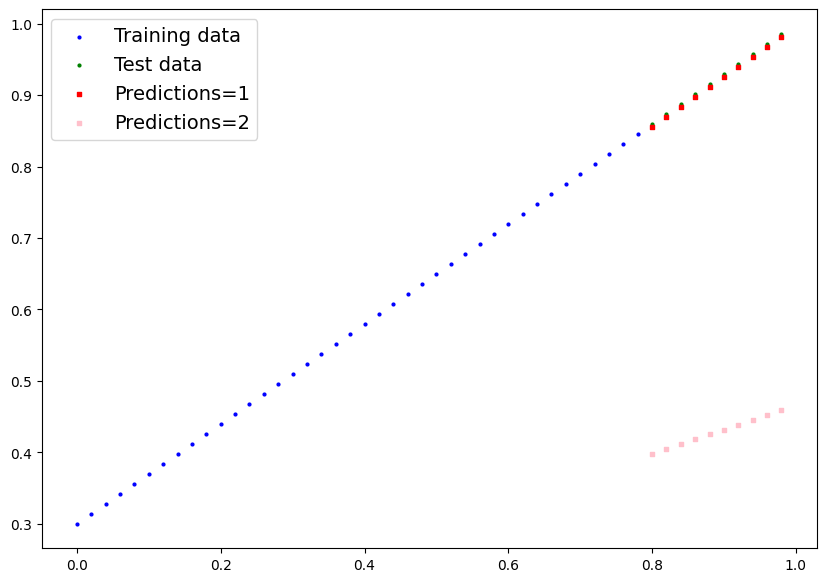

In [21]:
plot_predictions(predictions=[y_preds_new, y_preds])